# Existing and Schools New to the CEP program

In [1]:
import pandas as pd
import numpy as np
import time
import multiprocessing as mp
import matplotlib.pyplot as plt
%matplotlib inline 
#plt.style.use('seaborn-poster')
#plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_context('poster',font_scale=1.2)

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
#constants

multiplier = 1.6

# combined Federal and NY State meal reimbursement rates
freeLunch = 3.2999
paidLunch = 0.4399
freeBreakfast = 2.1413
paidBreakfast = 0.2923

deltaLunchRate = freeLunch - paidLunch
deltaBreakfastRate = freeBreakfast - paidBreakfast 

t_min = 0.40 * multiplier

# reading in data
doeNew = pd.read_excel('data/Test Data for CEP Grouping.xlsx',sheetname="School Data",header=2)
doeNew.rename(columns={'Identified Student Count':'Identified'},inplace=True)

doeExist = pd.read_excel('data/Additional Test Data for CEP Grouping, Pre-Existing Groups.xlsx',
                           sheetname='School Data',header=4)
doeExist.rename(columns={'Count':'Identified'},inplace=True)

# pre existing threshold
doeExistGroup = pd.read_excel('data/Additional Test Data for CEP Grouping, Pre-Existing Groups.xlsx',
                             sheetname='Group Data',header=4)
doeExistGroup=doeExistGroup[['Group','Free']]
doeExistGroup.rename(columns={'Free':'oldThreshold'},inplace=True)

doeExist = doeExist.merge(doeExistGroup,how='left',on='Group')
doeExist.rename(columns={'Group':'oldGroup'},inplace=True)

# assume only schools with >0 enrollment can be part of cep program.
cepNew = doeNew[doeNew.Enrollment>0].copy()
cepNew.reset_index(inplace=True)

cepExist = doeExist[doeExist.Enrollment>0].copy()
cepExist.reset_index(inplace=True)


# define a few more columns that are useful.
# 'meal' is the max reimbursement of meals per year for each school.
# 'mealPerStudent' is the max per student.
# 'baseThreshold' is the threshold of the school if it is not grouped.

cepNew['meal'] = deltaLunchRate*cepNew['Lunch'] + deltaBreakfastRate*cepNew['Breakfast']
cepExist['meal'] = deltaLunchRate*cepExist['Lunch'] + deltaBreakfastRate*cepExist['Breakfast']

cepNew['paidMeal'] = paidLunch*cepNew['Lunch'] + paidBreakfast*cepNew['Breakfast']
cepExist['paidMeal'] = paidLunch*cepExist['Lunch'] + paidBreakfast*cepExist['Breakfast']

cepNew['mealPerStudent'] = cepNew['meal']/cepNew['Enrollment']
cepExist['mealPerStudent'] = cepExist['meal']/cepExist['Enrollment']

cepNew['baseThreshold'] = cepNew['Identified']/cepNew['Enrollment']*multiplier
cepExist['baseThreshold'] = cepExist['Identified']/cepExist['Enrollment']*multiplier

In [3]:
cepNew.head()

,index,School,Enrollment,Identified,Breakfast,Lunch,meal,paidMeal,mealPerStudent,baseThreshold
0,0,1019,268.0,114.0,13744.040323,32119.415317,117274.258362,18146.713784,437.590516,0.680597
1,1,1025,188.0,121.0,2660.633468,8954.467200,30529.287474,4716.773284,162.389827,1.029787
2,2,1034,348.0,262.0,18359.910484,39773.741129,147700.374114,22863.070557,424.426362,1.204598
3,3,1060,679.0,293.0,7340.885081,19996.654634,70763.728769,10942.269083,104.217568,0.690427
4,4,1061,291.0,99.0,4320.555242,25602.863216,81212.895439,12525.597826,279.082115,0.544330


In [4]:
cepExist.head()

,index,School,Enrollment,Identified,Breakfast,Lunch,oldGroup,oldThreshold,meal,paidMeal,mealPerStudent,baseThreshold
0,0,2169,80.00,60.60,28965,22739,A,0.999717,118589.825,18469.3556,1482.372813,1.212000
1,1,2809,42.75,26.25,10710,15957,A,0.999717,65439.810,10150.0173,1530.755789,0.982456
2,2,1895,34.20,19.80,5910,7773,A,0.999717,33158.370,5146.8357,969.542982,0.926316
3,3,3820,77.40,56.60,28373,28273,A,0.999717,133322.457,20730.7206,1722.512364,1.170026
4,4,11176,177.00,97.60,24687,26788,A,0.999717,122259.943,19000.0513,690.734141,0.882260


## Existing groups
There are 10 pre-existing groups

In [5]:
cepExist.groupby('oldGroup').count()[['School']]

,School
oldGroup,
A,428
B,158
C,8
D1,27
D2,6
D3,6
D4,17
D5,29
D6,4


In [6]:
cepExist.groupby('oldGroup').sum()[['Enrollment']].apply(lambda x: np.round(x,-3)).sort_values('Enrollment')

,Enrollment
oldGroup,
D3,1000.0
D6,1000.0
D2,2000.0
C,4000.0
D4,7000.0
D5,13000.0
D1,15000.0
B,28000.0
F,103000.0


In [7]:
cepExist.groupby('oldGroup').mean()[['oldThreshold']]

,oldThreshold
oldGroup,
A,0.999717
B,0.640014
C,0.804585
D1,0.943506
D2,0.819100
D3,0.773887
D4,0.865564
D5,0.757873
D6,0.836991


In [8]:
print 'number of students in existing CEP',cepExist.Enrollment.sum()
print 'number of students in potential CEP',cepNew.Enrollment.sum()
print 'total students =',cepExist.Enrollment.sum()+cepNew.Enrollment.sum()

number of students in existing CEP 310435.819712
number of students in potential CEP 726513.966002
total students = 1036949.78571


In [9]:
print cepExist.shape
print cepNew.shape

(927, 12)
(1453, 10)


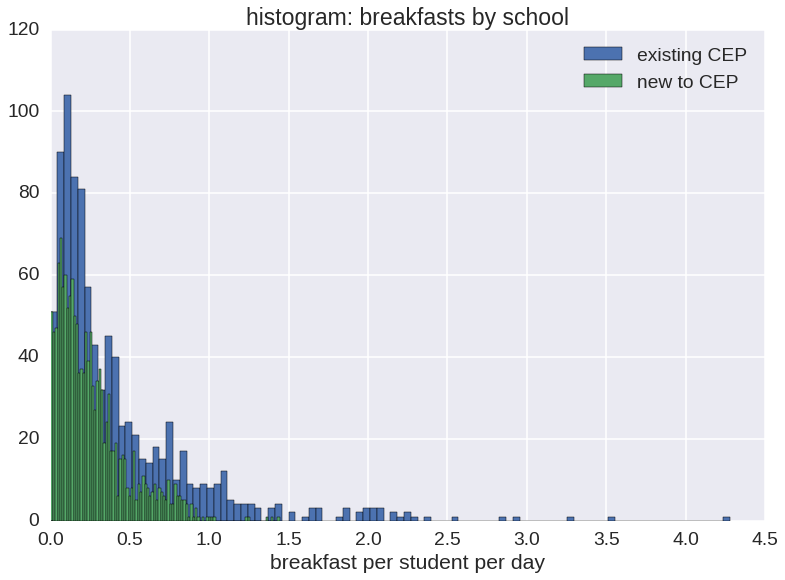

In [10]:
(cepExist.Breakfast/cepExist.Enrollment/180).hist(bins=100,label='existing CEP')
(cepNew.Breakfast/cepNew.Enrollment/180).hist(bins=100,label='new to CEP')
plt.legend()
plt.xlabel('breakfast per student per day')
plt.title('histogram: breakfasts by school')

In [11]:
print 'avg breakfasts per student in existing CEP schools',(cepExist.Breakfast/cepExist.Enrollment/180).mean()
print 'avg breakfasts per student in new to CEP schools',(cepNew.Breakfast/cepNew.Enrollment/180).mean()

avg breakfasts per student in existing CEP schools 0.426909045971
avg breakfasts per student in new to CEP schools 0.258292261185


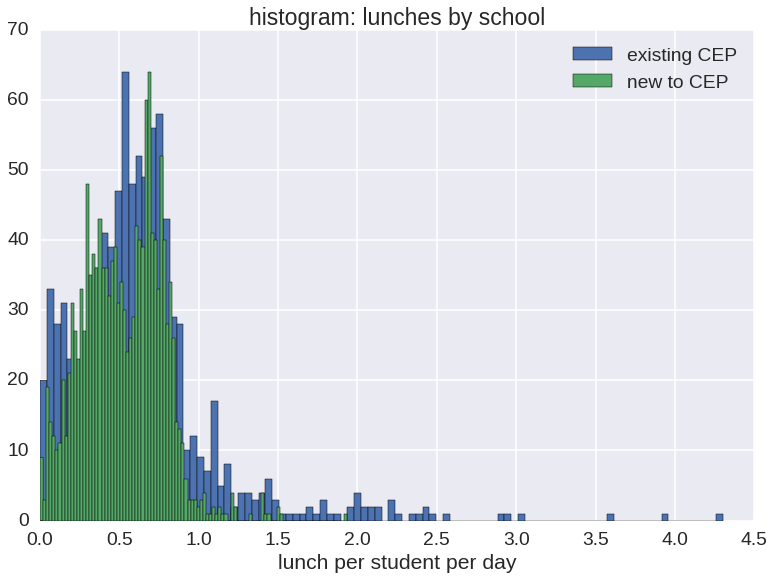

In [12]:
(cepExist.Lunch/cepExist.Enrollment/180).hist(bins=100,label='existing CEP')
(cepNew.Lunch/cepNew.Enrollment/180).hist(bins=100,label='new to CEP')
plt.legend()
plt.xlabel('lunch per student per day')
plt.title('histogram: lunches by school')

In [13]:
print 'avg lunches per student in existing CEP schools',(cepExist.Lunch/cepExist.Enrollment/180).mean()
print 'avg lunches per student in new to CEP schools',(cepNew.Lunch/cepNew.Enrollment/180).mean()

avg lunches per student in existing CEP schools 0.641687976906
avg lunches per student in new to CEP schools 0.526503517235


The projected meals for the existing CEP schools are higher on average than for schools new to CEP. So reimbursements from the new schools will likely be higher than projected.

## Calculating Reimbursements based on school groupings

In [14]:
# reimbursements over the base, this is the part that's dependant on groupings
def calcReimburse(cep,cost=0):
    ''' calculates and returns the total reimbursments (above base) for schools in a particlar grouping 
    Parameters:
    cep: dataframe where each row is a school. cep columns include: Identified, Enrollment, meal, group
    cost: cost = 0 (default) no cost to dropping schools from the program
          cost = 1 sets a high penalty for letting a group go below the min threshold'''
    
    # df - each row represents a group
    group_cep = cep.groupby('group')
    df = pd.DataFrame(index= group_cep.indices)

    df['threshold'] =  (group_cep['Identified'].sum()  / group_cep['Enrollment'].sum()) * multiplier
    df['meal']      =  group_cep['meal'].sum()
    
    # enforcing threshold rules:
    df['applied_threshold'] = df['threshold']
    df.loc[df['applied_threshold']  > 1, 'applied_threshold'] = 1
    df.loc[df['applied_threshold']  < t_min,'applied_threshold'] = 0 - cost*10**6

    df['reimbursed'] = df['applied_threshold'] * df['meal']
    
    return df.reimbursed.sum()

def setThreshold(cep):
    ''' calculates the threshold for each school based on its group
        cep columns: Enrollment, Identified'''
    for i in set(cep.group):
        df = cep[cep.group==i]
        cep.loc[cep.group == i,'threshold'] = df['Identified'].sum() / float(df['Enrollment'].sum()) * multiplier
    return 0

In [15]:
# reimbursements based on the old groupings
cepExist['oldReimburse'] = cepExist['oldThreshold']*cepExist['meal']
cepExist['oldReimburse'].sum()

117830076.13078761

In [16]:
#combine all schools, exisiting and new
cep = pd.concat([cepExist,cepNew],ignore_index=True)
cep.head()

,Breakfast,Enrollment,Identified,Lunch,School,baseThreshold,index,meal,mealPerStudent,oldGroup,oldReimburse,oldThreshold,paidMeal
0,28965.0,80.00,60.60,22739.0,2169,1.212000,0,118589.825,1482.372813,A,118556.296491,0.999717,18469.3556
1,10710.0,42.75,26.25,15957.0,2809,0.982456,1,65439.810,1530.755789,A,65421.308419,0.999717,10150.0173
2,5910.0,34.20,19.80,7773.0,1895,0.926316,2,33158.370,969.542982,A,33148.995244,0.999717,5146.8357
3,28373.0,77.40,56.60,28273.0,3820,1.170026,3,133322.457,1722.512364,A,133284.763182,0.999717,20730.7206
4,24687.0,177.00,97.60,26788.0,11176,0.882260,4,122259.943,690.734141,A,122225.376850,0.999717,19000.0513


## Calculate Optimal Solution using Monte Carlo -- Simulated Annealing
similar to stochastic hill climbing, but allows downwards steps as well

In [24]:

def simulated_annealing(cep, randomstart=True, seed=None,
                        ngroupstart=1,ngroups=10, Tmax=1, deltaT=0.1):
    '''run simulated annealing procedure on datafram cep'''
    
    startTime = time.time()
    cep.reset_index(drop=True,inplace=True) 
    rows=cep.shape[0]

    # start by grouping schools randomly
    if randomstart:
        np.random.seed(seed)
        cep.loc[:,'group'] = pd.Series(np.random.randint(0,ngroupstart,size=rows),
                                       index=cep.index)

    # store the results
    old = calcReimburse(cep)
    results=[old]

    # mc loop
    for T in np.arange(Tmax,0,-deltaT):
        for i in range(1000):
            df = cep.copy()
            
            # choose a random school and move it to a different random group
            df.loc[np.random.randint(0,rows),'group'] = np.random.randint(0,ngroups)
                                                                                   
            # calculate the reimbursement
            new = calcReimburse(df,cost=1)
            step = new - old                                                                           
            
            #keep move if reimbursement increases
            if (step > 0):
                old=new
                cep.loc[:,'group'] = df.group
                results.append(new)
                
            #maybe keep move if reimbursement decreases, depending on how much
            elif (np.random.uniform() < np.exp(step/T)):
                old=new
                cep.loc[:,'group'] = df.group
                results.append(new)

    cep = regroup(cep) #combining groups close by
    final = calcReimburse(cep)
    results.append(final)
    print final
    print 'time in h', (time.time()-startTime)/60.0/60.0
    return results,cep


def regroup(cep):
    '''if cep has multiple thresholds within one percent of each other, this 
    combines them'''
    setThreshold(cep)
    tlist = cep.groupby(cep.threshold.apply(lambda x: round(x,2))).groups.keys()
    for i,t in enumerate(tlist):
        cep.loc[cep.threshold.apply(lambda x:round(x,2))==t,'group']=i
    setThreshold(cep)
    return cep

def sa_ensemble(cep,trials=10,randomstart=True,ngroupstart=1,ngroups=10,Tmax=1,deltaT=.1):
    '''run simulated annealing a number of times (trials) and choose the best 
    (highest reimbursement) as the final'''
    pool = mp.Pool(processes=4) # parrallel over 4 cores
    results = [pool.apply_async(simulated_annealing,
                                args=(cep,)) for x in range(trials)]
    results = [p.get() for p in results]
    
    reimb_ensemble = [results[i][0][-1] for i in range(trials)]
    cep_ensemble = [results[i][1] for i in range(trials)]
    
    max_reimb = max(reimb_ensemble)
    max_index = reimb_ensemble.index(max_reimb)

    return cep_ensemble[max_index]



### Optimize schools in already existing groups
as if the old groups don't exist

In [22]:
sa, cepExist = simulated_annealing(cepExist, Tmax=1,deltaT=.01)

111314216.474
time in h 0.119299156931


In [59]:
# than old groupings parameters give a larger result
cepExist['oldReimburse'].sum()

117830076.13078761

###Range of outcomes on grouping all schools new to cep
Running 10 trials on the new schools to get a range of values. The uncertainty is on the order of 10^5. 

In [29]:
%%capture
trials=pd.DataFrame(columns=['final'])

for i in range(10):
    sa,cepNew=simulated_annealing(cepNew,Tmax=1,deltaT=.01)
    trials.loc[i,'final'] = sa[-1]
trials

,final
0,1.87946e+08
1,1.88167e+08
2,1.88456e+08
3,1.88166e+08
4,1.88312e+08
5,1.88278e+08
6,1.88072e+08
7,1.87879e+08
8,1.88025e+08
9,1.88392e+08


In [30]:
print trials.max()
print trials.min()
print trials.max()-trials.min()

final    1.884561e+08
dtype: float64
final    1.878786e+08
dtype: float64
final    577438.637687
dtype: float64


### optimize within old groupings
Optimizing within each of the groups using current parameters always yeilds less reimbursement than using the old group thresholds. 

This is an inconclusive result, since optimizing with the larger group can still potentially yeild better results than the old thresholds.

In [31]:
%%capture

ind=pd.DataFrame(columns=['sa'])
grouped = cepExist.groupby('oldGroup')

for name,group in grouped:
    sa,group = simulated_annealing(group,Tmax=1,deltaT=.01)
    ind.loc[name,'sa'] = sa[-1]

ind['oldReimburse']=grouped.sum()[['oldReimburse']]
ind['diff'] = ind['sa'] - ind['oldReimburse']
ind

,sa,oldReimburse,diff
A,5.58522e+07,6.017225e+07,-4.32006e+06
B,0,4.016719e+06,-4.01672e+06
C,799406,8.053003e+05,-5894.04
D1,4.76193e+06,5.256260e+06,-494329
D2,449538,5.353246e+05,-85786.7
D3,0,2.137252e+05,-213725
D4,1.7379e+06,1.921443e+06,-183542
D5,2.26777e+06,2.516527e+06,-248760
D6,282383,3.049104e+05,-22527.5
F,4.09679e+07,4.208761e+07,-1.11972e+06


### Try all combinations of groupings

Groups C and D1-D6 are relativly small, less than 100 schools total (and less than 5% of the student population). 

In order to make this problem tractable, let's combine and treat them the same -- either they all keep the old groupings or they all get regrouped. This reduces the number of possibilites from 2^10=1024 to 2^4=16.

Try all possibilites and see which returns the highest reimbursement.

In [48]:
cepExist.groupby('oldGroup').count()[['School']]

,School
oldGroup,
A,428
B,158
C,8
D1,27
D2,6
D3,6
D4,17
D5,29
D6,4


In [56]:
cepExist[cepExist.oldGroup.str.contains('C|D')].Enrollment.sum()/\
(cepExist.Enrollment.sum()+cepNew.Enrollment.sum())

0.040457481580007094

In [20]:
from itertools import product

columns = ['A','B','CD','F']
regroupings = pd.DataFrame(list(product(['yes','no'],repeat=4)),columns=columns)
# yes means to regroup. no means hold on to old group

cep['OGname']=cep['oldGroup']
cep.loc[cep['oldGroup'].fillna('-').str.contains('D|C'),'OGname'] = 'CD'

cep.groupby(['oldGroup','OGname']).count()

,,Breakfast,Enrollment,Identified,Lunch,School,baseThreshold,index,meal,mealPerStudent,oldReimburse,oldThreshold,paidMeal
oldGroup,OGname,,,,,,,,,,,,
A,A,428,428,428,428,428,428,428,428,428,428,428,428
B,B,158,158,158,158,158,158,158,158,158,158,158,158
C,CD,8,8,8,8,8,8,8,8,8,8,8,8
D1,CD,27,27,27,27,27,27,27,27,27,27,27,27
D2,CD,6,6,6,6,6,6,6,6,6,6,6,6
D3,CD,6,6,6,6,6,6,6,6,6,6,6,6
D4,CD,17,17,17,17,17,17,17,17,17,17,17,17
D5,CD,29,29,29,29,29,29,29,29,29,29,29,29
D6,CD,4,4,4,4,4,4,4,4,4,4,4,4


In [21]:
%%capture
for i in range(regroupings.shape[0]):
    df = cep.merge(regroupings.loc[i].to_frame('regroup'),how='left',
                   left_on='OGname',right_index=True)

    #calculate based on groups
    cepRegroup = df[df.regroup!='no'].copy()
    cepOldgroup = df[df.regroup=='no'].copy()

    cepRegroup = sa_ensemble(cepRegroup,trials=100,Tmax=1,deltaT=.01)
    
    totalR = calcReimburse(cepRegroup)+cepOldgroup['oldReimburse'].sum()
    regroupings.loc[i,'reimburse']=totalR

In [22]:
regroupings

,A,B,CD,F,reimburse
0,yes,yes,yes,yes,3.000956e+08
1,yes,yes,yes,no,3.006581e+08
2,yes,yes,no,yes,3.008823e+08
3,yes,yes,no,no,3.010711e+08
4,yes,no,yes,yes,3.011767e+08
5,yes,no,yes,no,3.015508e+08
6,yes,no,no,yes,3.018676e+08
7,yes,no,no,no,3.021707e+08
8,no,yes,yes,yes,3.042381e+08
9,no,yes,yes,no,3.043722e+08


### Result
the best outcome (highest reimbursement) is to keep the existing groups as they are.


### Output
For the schools new to CEP, take the best of 5000 simmulated annealing runs. Save the results to csv file

In [18]:
%%capture
cepNew = sa_ensemble(cepNew,trials=5000,Tmax=1,deltaT=.01)
calcReimburse(cepNew)

188445169.87128472

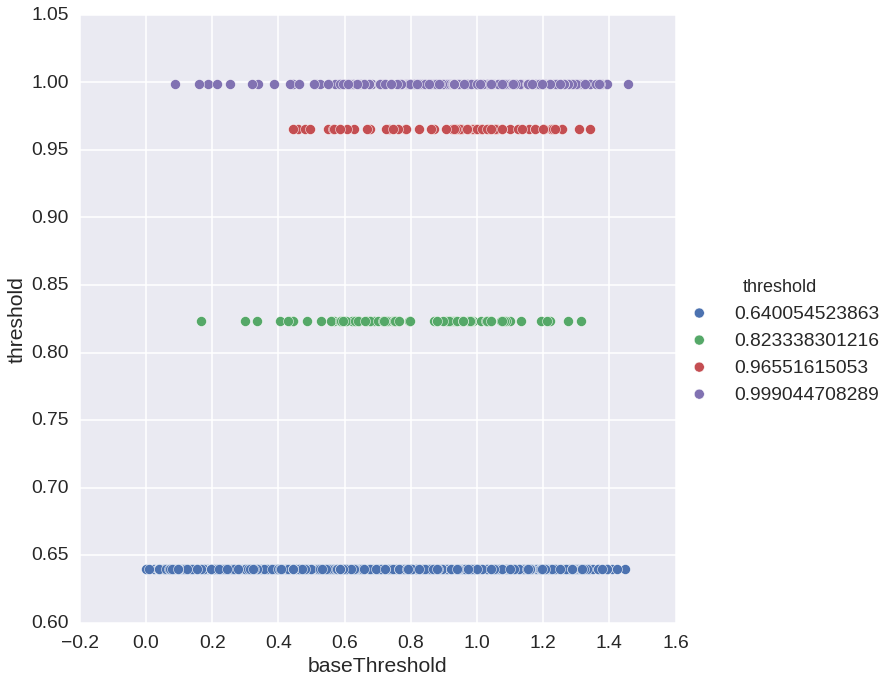

In [20]:
sns.pairplot(x_vars=['baseThreshold'],y_vars=['threshold'],data=cepNew, hue='threshold',
             size=10,plot_kws={'s':100})

In [56]:
cepNew.groupby(['threshold','group']).count()[['School']]

,,School
threshold,group,
0.640055,2,961
0.823338,3,91
0.965516,1,64
0.999045,0,337


In [69]:
doeFinal = doeNew.merge(cepNew[['School','group','threshold']],how='left',on='School')
doeFinal.head()

,School,Enrollment,Identified,Breakfast,Lunch,group,threshold
0,1019,268.0,114.0,13744.040323,32119.415317,2.0,0.640055
1,1025,188.0,121.0,2660.633468,8954.467200,2.0,0.640055
2,1034,348.0,262.0,18359.910484,39773.741129,0.0,0.999045
3,1060,679.0,293.0,7340.885081,19996.654634,2.0,0.640055
4,1061,291.0,99.0,4320.555242,25602.863216,2.0,0.640055


In [75]:
print doeFinal.group.count()
print doeNew.shape
print cepNew.shape
print doeNew[~doeNew.School.isin(cepNew.School)].shape
print doeFinal[~(doeFinal.group>=0)].shape

1453
(1487, 5)
(1453, 12)
(34, 5)
(34, 7)


In [76]:
# the 34 zero enrollment schools need to be added into the highest threshold group
doeFinal[doeFinal.Enrollment==0].shape

(34, 7)

In [85]:
#highest threshold
highTh = cepNew[cepNew.threshold>.99].threshold[2]
highTh

0.99904470828879455

In [86]:
#fill in zero enrollment schools
doeFinal.loc[doeFinal.Enrollment==0,'group']=0
doeFinal.loc[doeFinal.Enrollment==0,'threshold']=highTh

In [100]:
baseReimburse = paidLunch*doeFinal.Lunch.sum() + paidBreakfast*doeFinal.Breakfast.sum()

doeFinal['meal'] = deltaLunchRate*doeFinal['Lunch'] + deltaBreakfastRate*doeFinal['Breakfast']
finalR = calcReimburse(doeFinal)
doeFinal.drop('meal',axis=1,inplace=True)

baseReimburse+finalR

226457782.34617627

In [93]:
doeFinal.head()

,School,Enrollment,Identified,Breakfast,Lunch,group,threshold
0,1019,268.0,114.0,13744.040323,32119.415317,2.0,0.640055
1,1025,188.0,121.0,2660.633468,8954.467200,2.0,0.640055
2,1034,348.0,262.0,18359.910484,39773.741129,0.0,0.999045
3,1060,679.0,293.0,7340.885081,19996.654634,2.0,0.640055
4,1061,291.0,99.0,4320.555242,25602.863216,2.0,0.640055


In [95]:
#print to file
doeFinal.to_csv('SchoolGroups.csv',index=False)

In [99]:
oneGroup = doeFinal.copy()
oneGroup.group=0
oneGroup['meal'] = deltaLunchRate*oneGroup['Lunch'] + deltaBreakfastRate*oneGroup['Breakfast']
ogr = calcReimburse(oneGroup)
ogr+baseReimburse

214803554.45200169